In [173]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
%matplotlib inline

# Когортный анализ LTV пользователей e-com сервиса британского ретейлера

Это транснациональный набор данных, содержащий все транзакции, произошедшие между 01.12.2010 и 09.12.2011 для зарегистрированной в Великобритании немагазинной интернет-торговли. Компания в основном продает уникальные подарки на все случаи жизни. Многие клиенты компании являются оптовиками

### LTV

`LTV, или Lifetime Value`, — пожизненная ценность клиента. Метрика показывает, сколько денег клиент принёс компании за всё время взаимодействия с ней. Это может быть и чистая прибыль от клиента, и доход от всех его заказов.

Метрику используют, чтобы понять, оправданы ли затраты на привлечение, вовлечение и удержание клиента.

$$ LTV = \frac{Суммарный\ доход\ за\ определенный\ период}{Количество\ пользователей} $$

### Предобработка данных

In [94]:
df = pd.read_csv('ecom_data.csv', encoding='1251', parse_dates=['InvoiceDate'])
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Оставим колонки, необходимые для анализа LTV: ID клиента, дата заказа, сумма заказа.

In [95]:
df['OrderSum'] = df.UnitPrice * df.Quantity

In [96]:
df = df[['CustomerID', 'InvoiceDate', 'OrderSum']]
df.InvoiceDate = df.InvoiceDate.dt.date

Имеются данные за целый календарный год, когорты можно построить по месяцам.

In [97]:
print(f"Данные предоставлены за период с {df.InvoiceDate.min()} по {df.InvoiceDate.max()}")

Данные предоставлены за период с 2010-12-01 по 2011-12-09


In [98]:
df.isna().sum()

CustomerID     135080
InvoiceDate         0
OrderSum            0
dtype: int64

Данные, где не указан ID клиента не будут иметь практического значения для когортного анализа, их нужно удалить.

In [99]:
df = df[~df.CustomerID.isna()]
df.CustomerID = df.CustomerID.astype(int)

### Составление когорт

In [102]:
customers_cohorts = df.groupby('CustomerID', as_index=False).InvoiceDate.min()
customers_cohorts['InvoiceDate'] = pd.to_datetime(customers_cohorts['InvoiceDate']).dt.strftime("%Y-%m-01")
customers_cohorts.rename(columns=({'InvoiceDate' : 'Cohort'}), inplace=True)
customers_cohorts.head()

,CustomerID,Cohort
0,12346,2011-01-01
1,12347,2010-12-01
2,12348,2010-12-01
3,12349,2011-11-01
4,12350,2011-02-01


Соединим когорты с данными о заказах каждого пользователя.

Будем считать LTV в разрезе: месяц от первого заказа, два месяца, три месяца, полгода, год.

Для этого посчитаем у каждого пользователя разницу между датой очереднего и первого заказа в днях, далее эту разницу поделим по необходимым нам периодам.

In [230]:
merged_df = df.merge(customers_cohorts, on='CustomerID')
merged_df.InvoiceDate = pd.to_datetime(merged_df.InvoiceDate)
merged_df.Cohort = pd.to_datetime(merged_df.Cohort)
merged_df['Diff'] = (merged_df.InvoiceDate - merged_df.Cohort).dt.days
merged_df['DiffPeriods'] = pd.cut(merged_df.Diff, bins=[-1,0,7,30,60,90,180,360], labels=['0','7','30','60','90','180','360'])
merged_df

,CustomerID,InvoiceDate,OrderSum,Cohort,Diff,DiffPeriods
0,17850,2010-12-01,15.30,2010-12-01,0,0
1,17850,2010-12-01,20.34,2010-12-01,0,0
2,17850,2010-12-01,22.00,2010-12-01,0,0
3,17850,2010-12-01,20.34,2010-12-01,0,0
4,17850,2010-12-01,20.34,2010-12-01,0,0
...,...,...,...,...,...,...
406824,12680,2011-12-09,10.20,2011-08-01,130,180
406825,12680,2011-12-09,12.60,2011-08-01,130,180
406826,12680,2011-12-09,16.60,2011-08-01,130,180
406827,12680,2011-12-09,16.60,2011-08-01,130,180


### Расчет LTV по когортам

In [231]:
ltv_cohorts = pd.pivot_table(merged_df, index='Cohort', columns = 'DiffPeriods', values = 'OrderSum', aggfunc= 'sum')
ltv_cohorts.loc[:, ltv_cohorts.columns[ltv_cohorts.columns.astype(int) >= 30]] = ltv_cohorts.loc[:, ltv_cohorts.columns.astype(int) >= 30].replace(0, np.nan)
cohorts_sizes = merged_df.groupby('Cohort').CustomerID.nunique().to_list()
ltv_cohorts = ltv_cohorts.cumsum(axis = 1).divide(cohorts_sizes, axis = 0)
ltv_cohorts


C:\Users\фвьшт\AppData\Local\Temp\ipykernel_14396\3318971116.py:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  ltv_cohorts = pd.pivot_table(merged_df, index='Cohort', columns = 'DiffPeriods', values = 'OrderSum', aggfunc= 'sum')


DiffPeriods,0,7,30,60,90,180,360
Cohort,,,,,,,
2010-12-01,48.577278,282.115506,585.025338,858.427479,1125.781572,1976.501519,4385.071255
2011-01-01,0.000000,84.068242,483.272827,621.983990,768.453230,1258.266770,2378.443185
2011-02-01,24.039789,101.734579,395.873289,474.893737,560.368579,854.838579,1447.676816
2011-03-01,24.848409,132.661000,431.659273,491.621091,609.799318,897.040045,1350.762659
2011-04-01,22.201338,110.238361,400.549334,497.275187,580.646625,838.868264,1075.487829
2011-05-01,5.801004,84.282760,415.264301,478.575950,543.698100,819.843154,974.416523
2011-06-01,7.241532,94.713149,393.708128,451.684511,510.351915,893.694468,951.021191
2011-07-01,6.722827,91.998063,344.936497,403.360005,482.496707,706.872152,NaN
2011-08-01,43.467365,174.043293,465.019341,579.525329,745.775868,1101.260659,NaN


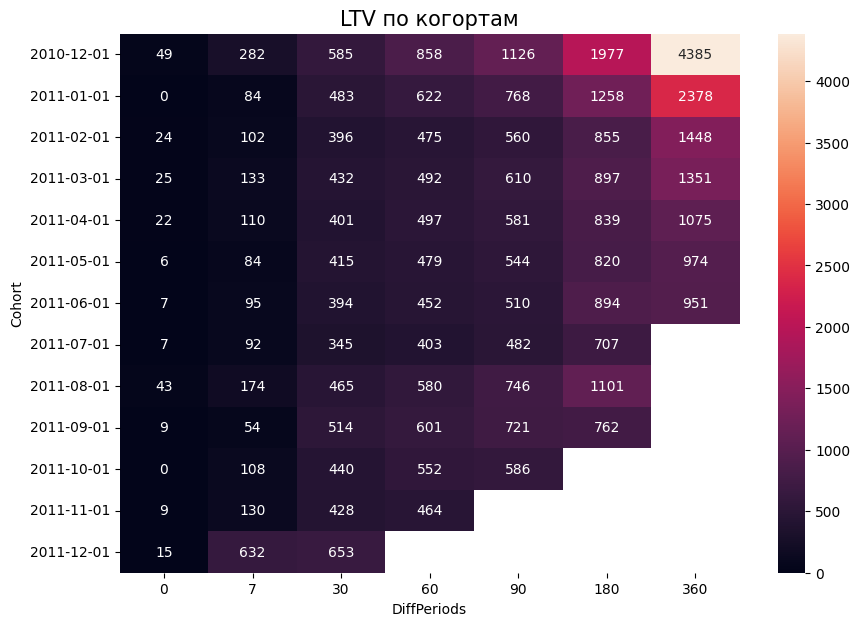

In [232]:
fig,ax = plt.subplots(figsize=(10,7))
plt.title("LTV по когортам", fontsize=15)
sns.heatmap(ltv_cohorts, annot=True, fmt=".0f")
formatted_labels = [pd.to_datetime(label).strftime('%Y-%m-%d') for label in list(ltv_cohorts.index.date)]
ax.set_yticklabels(formatted_labels); 

### Выводы

1. LTV в первую неделю привлечения клиента мал, клиент начинает приносить достаточно высокую выручку к концу первого месяца пользования сервисом.
2. Для некоторых когорт наблюдается замедление роста LTV в долгосрочной перспективе, что может указывать на недостаточную работу с повторными покупками или сниженный интерес клиентов к продуктам.
3. С каждой новой когортой LTV периода 180-360 дней с момента первой покупки снижается, что опять же указывает на снижение интереса клиентов к сервису, особенно после полгода пользования.
4. Новая когорта, начавшаяся 1 декабря 2011 года, показывает заметно более высокий LTV уже на 30-дневном периоде. Это может свидетельствовать об успешной маркетинговой кампании или более эффективных стратегиях привлечения.

**Рекомендации**

1. Работа над увеличением начального LTV у новых когорт: приветственный бонус, проведение акций.
2. Сфокусироваться на удержании клиентов, особенно после того как прошло полгода с момента первой покупки: например рассылки, предложение подборки ходовых товаров.
3. Внедрить персонализацию подхода, у сервиса много оптовых клиентов, стоит придумать для них персональные предложения, это может помочь увеличить начальный LTV и дальнейшую вовлеченность в продукт.

**Что стоит доисследовать**
1. Когортный анализ, но уже метрики Retention, чтобы видеть процент возвращаемости у клиентов с течением времени.
2. В связи с чем происходит резкое увеличение LTV 7 дня и в последствии увеличение 30 дня у когорты декабря 2011 года, возможно была успешная маркетинговая компания, на которую следует ориентироваться в дальнейшем
3. Сколько компания тратит на привлечение одного клиента?



> 📌 Обязательно стоит следить за тем, чтобы LTV превышал CAC(стоимость привлечения клиента), желательно чтобы CAC составлял меньше 30% от LTV